In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.18.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


Using CNN for Image Classification on CIFAR-10 Dataset

CIFAR-10 is a very popular computer vision dataset provided by the Canadian Institute For Advanced Research (CIFAR). This dataset is used in many types of deep learning research for object recognition.

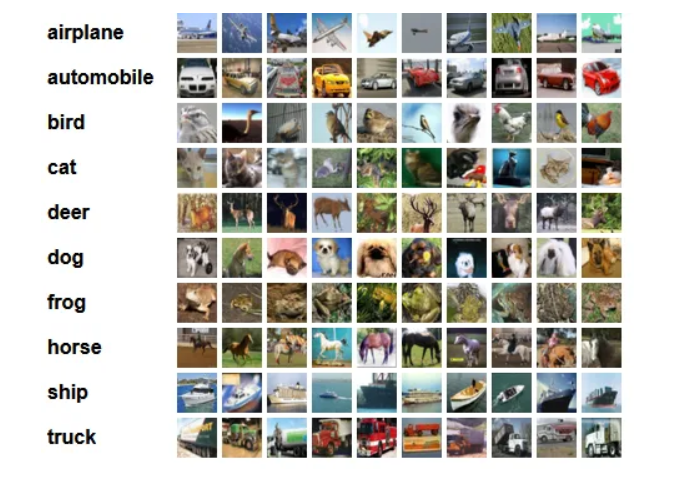

There are 60,000, 32x32 color images from these 10 classes, with 6000 images from each class. The training dataset contains 50,000 training images and the test dataset contains 10,000 test images.

The classes are mutually exclusive and there is no overlap between them.

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

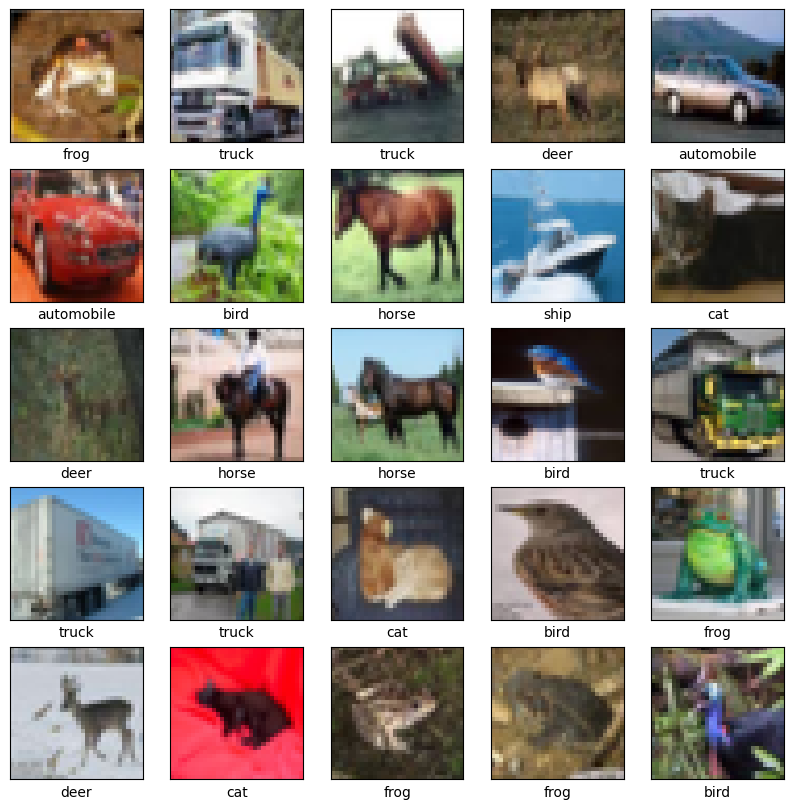

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])

plt.show()

Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to your first layer.

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

None


Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [10]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10))
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.3541 - loss: 1.7497 - val_accuracy: 0.5485 - val_loss: 1.2747
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5713 - loss: 1.2101 - val_accuracy: 0.6256 - val_loss: 1.0671
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.6389 - loss: 1.0234 - val_accuracy: 0.6279 - val_loss: 1.0650
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.6767 - loss: 0.9205 - val_accuracy: 0.6720 - val_loss: 0.9326
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7067 - loss: 0.8375 - val_accuracy: 0.6746 - val_loss: 0.9653
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7288 - loss: 0.7763 - val_accuracy: 0.6944 - val_loss: 0.8997
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7487 - loss: 0.7129 - val_accuracy: 0.7064 - val_loss: 0.8730
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7623 -

Evaluate the model

313/313 - 2s - 6ms/step - accuracy: 0.7164 - loss: 0.8562


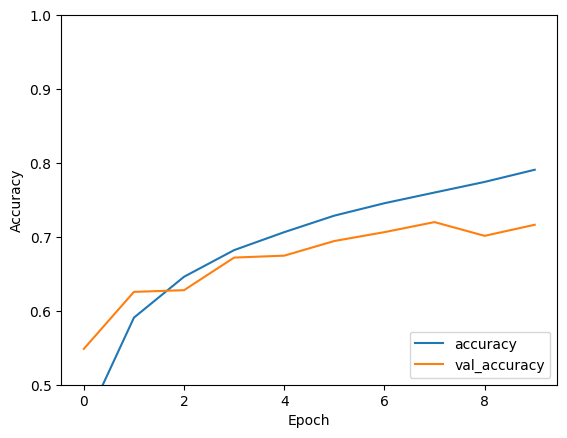

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [13]:
print(test_acc)

0.7164000272750854
